In [1]:
%reload_ext autoreload
%autoreload 2

### Issues with MASHUP:

1) The main thing I noticed about MASHUP is, it dilutes the intra-network local relationships between proteins in the network. One way it does it is by computing the lazy random walk across all the nodes in the network, and mashing them all together. 

2) So the distinction between networks, and local clusters within the networks is somewhat diluted.

## Model Description 

The main thrust of our method is:
1) Use trainable GNN to extract the network based similarity between protein pairs across the network (through the use of graph attention)
2) Use it to create better network sensitive embedding, which after passing through a sigmoid layer could be used for better classifi


### Architecture
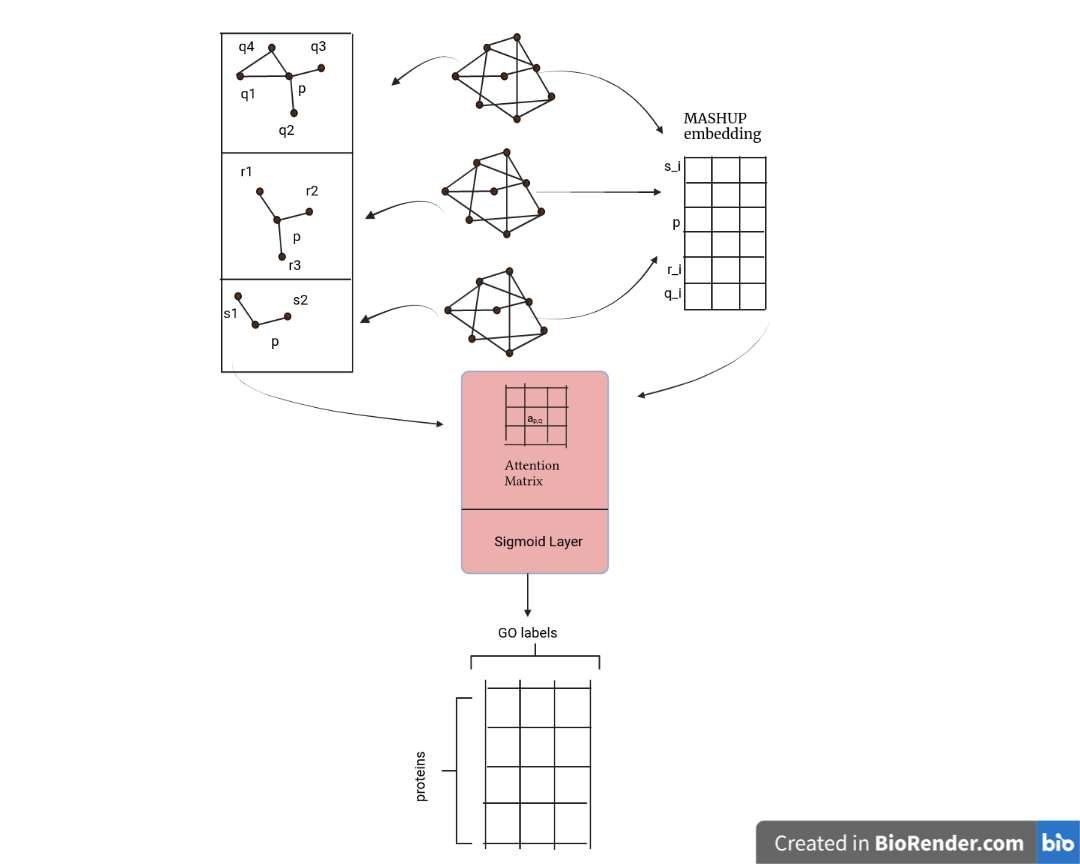


### Changes over the original Graph Attention Network.

This new model incorporates many changes over the existing GAN.

1) GAN needed a lot of GPU space to operate, since it loaded the whole Adjacency matrix, and computed the network-wide attention for each epoch.

2) GAN was not suited for multi-graph scenarios.

Our method is comparatively cheaper in both memory and time constraints, and it allows for multi-graph operations.

## Generating Labels

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../")
from mgattention.parse_protein_symbols import entrez_dict
from mgattention.process_labels.get_labels import get_go_labels

def get_labels(proteins,
               obofile,
               g2gofile,
               entrez_map,
               go_type = "molecular_function",
               min_level = 5,
               min_protein_annotation = 50,
               symbol_to_id = lambda x:x):
    """
    Get the protein GO labels corresponding to a given protein.
    """
    filter_protein = {"namespace": go_type, "lower_bound": min_protein_annotation}
    filter_labels  = {"namespace": go_type, "min_level": min_level}
    symbol_to_entrez, entrez_to_symbol = entrez_dict(entrez_map)
    entrez_prots  = {symbol_to_entrez[p] 
                     for p in proteins if p in symbol_to_entrez}
    f_labels, labels_dict = get_go_labels(filter_protein,
                                          filter_labels,
                                          entrez_prots,
                                          lambda x: symbol_to_id(entrez_to_symbol[x]),
                                          g2gofile,
                                          obofile,
                                          verbose = True)
    
    return f_labels, labels_dict


In [3]:
import json
with open("../datasets/network/dream/extracted/networks/nodemap_dim_1000.json", "r") as jf:
    nodemap = json.load(jf)

In [4]:
proteins = {k for k in nodemap}
f_labels, l_dict = get_labels(proteins,
                             "../datasets/go/extracted/go-basic.obo",
                             "../datasets/go/extracted/gene2go",
                              "../idmap.csv",
                             symbol_to_id = lambda x: nodemap[x])


HMS:0:00:16.506744 335,858 annotations, 20,671 genes, 18,441 GOs, 1 taxids READ: ../datasets/go/extracted/gene2go 
18388 IDs in loaded association branch, molecular_function
  EXISTS: ../datasets/go/extracted/go-basic.obo
../datasets/go/extracted/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 Terms; optional_attrs(relationship)
Labels Obtained! The number of labels obtained is 47


In [13]:
labels_mat  = np.zeros((len(proteins), len(f_labels)))
for i in range(len(f_labels)):
    labels_mat[l_dict[f_labels[i]], i] = 1

In [17]:
n_labels  = np.sum(labels_mat, axis = 1)
id_no_labels = np.argwhere(n_labels == 0) 
id_labels_present = np.delete(np.arange(len(proteins)).astype(int), id_no_labels)

In [18]:
len(id_labels_present), len(id_no_labels)

(6700, 12035)

### Getting Test and Train Labels

In [19]:
shuffle_labels_id = np.random.permutation(id_labels_present)
all_labels      = len(id_labels_present)
train_ids       = shuffle_labels_id[0: int(3/4 * all_labels)]
test_ids        = shuffle_labels_id[int(3/4 * all_labels): ]
train_ids, test_ids

(array([ 7097,  6690, 13121, ..., 15362, 18188,  2540]),
 array([ 8457,  9093,  2638, ...,  9881, 18538,  9744]))

### Constructing M

In [81]:
from mgattention.models.layers import MGAT
model = MGAT(1000, 
             100, 
             47, 
             0.3, 
             0.3, 
             5,
            no_networks = 3)

In [63]:
import torch
adj_loc  = "../datasets/network/dream/extracted/networks/"
adj_files = ["dream_1.txt", "dream_2.txt", "dream_3.txt"]
adj_mats = []
adj_sum  = 0
for f in adj_files:
    adj_mat = np.zeros((len(nodemap), len(nodemap)))
    print(f"Processing file {f}")
    ps   = []
    qs   = []
    val  = []
    with open(f"{adj_loc}/{f}", "r") as rf:
        for line in rf:
            p, q, w = line.strip().split()
            p_      = nodemap[p]
            q_      = nodemap[q]
            adj_mat[p_, q_] = float(w)
            adj_mat[q_, p_] = float(w)
        adj_sum += adj_mat
    adj_mats.append(adj_mat)

Processing file dream_1.txt
Processing file dream_2.txt
Processing file dream_3.txt


In [82]:
torch.cuda.set_device(5)
model.cuda()

MGAT(
  (attention_0): MultiGraphAttention(
    (leakyrelu): LeakyReLU(negative_slope=0.3)
    (sm): Softmax(dim=0)
  )
  (attention_1): MultiGraphAttention(
    (leakyrelu): LeakyReLU(negative_slope=0.3)
    (sm): Softmax(dim=0)
  )
  (attention_2): MultiGraphAttention(
    (leakyrelu): LeakyReLU(negative_slope=0.3)
    (sm): Softmax(dim=0)
  )
  (attention_3): MultiGraphAttention(
    (leakyrelu): LeakyReLU(negative_slope=0.3)
    (sm): Softmax(dim=0)
  )
  (attention_4): MultiGraphAttention(
    (leakyrelu): LeakyReLU(negative_slope=0.3)
    (sm): Softmax(dim=0)
  )
  (out_att): MultiGraphAttention(
    (leakyrelu): LeakyReLU(negative_slope=0.3)
    (sm): Softmax(dim=0)
  )
)

In [90]:
def compute_neighbors(mat, i, neighbors = 50):
    return np.append([i], np.argsort(-mat[i])[:neighbors])

def compute_neighbors_e(mats, i, neighbors = 10):
    nbrs = np.array([i])
    for m in mats:
        np.append(nbrs, np.argsort(-m[i][:neighbors]))
    return nbrs

def get_adjacency(adjs, neighbors, use_cuda = True):
    adjn = []
    for i in range(len(adjs)):
        amat = torch.from_numpy(adjs[i][neighbors][:, neighbors]).float()
        if use_cuda:
            amat = amat.cuda()
        adjn.append(amat)
    return adjn

In [83]:
labels = torch.from_numpy(labels_mat).float()
features = torch.from_numpy(np.abs(np.load("../datasets/network/dream/extracted/networks/dim_1000.npy"))).float()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr = 0.03, weight_decay = 9e-4)

In [84]:
# First epoch
import torch.nn.functional as F
from tqdm import tqdm

def computef1(pred, true, prnt = False):
    dim   = pred.shape[0]
    index = np.argsort(-pred)
    trues = np.sum(true)
    tp    = [np.sum(true[index[:i]]) for i in range(dim)]
    prec  = [t / (i + 1) for i,t in enumerate(tp)]
    rec   = [t / trues for t in tp]
    f1    = [0 if (p == 0 and r == 0) else 2 * p * r / (p+ r) for p, r in zip(prec, rec)]
    
    aupr  = 0
    pr    = 0
    for p, r in zip(prec, rec):
        aupr += (r - pr) * p
        pr   = r
        
    if prnt:
        print(aupr)
    return np.max(f1), aupr


for epoch in range(5):
    print(f"Running epoch {epoch}")
    model.train()
    f1 = 0
    aupr = 0
    for e in tqdm(range(train_ids.shape[0]), "Training"):
        i         = train_ids[e]
        optimizer.zero_grad()
        neighbors = compute_neighbors_e(adj_mats, i)
        adjs      = get_adjacency(adj_mats, neighbors, use_cuda = True)
        feat      = features[neighbors].cuda()
        labs      = labels[neighbors].cuda()
        output    = model(feat, adjs)
        loss      = F.binary_cross_entropy(output, labs)
        loss.backward()
        optimizer.step()
        output    = output.cpu()
        labs      = labs.cpu()
        
        # prnt      = True if e % 1000 == 0 else False
        f1_, aupr_ = computef1(output[0].detach().numpy(), labs[0].numpy(), prnt = False)
        f1         += f1_
        aupr      += aupr_
        for j in range(len(adjs)):
            adjs[j] = None
        feat       = None
        labs       = None
        output     = None
        loss       = None
    f1 /= train_ids.shape[0]
    aupr /= train_ids.shape[0]
    print(f"Training F1: {f1}, AUPR = {aupr}")
    print(f"Testing..")
    model.eval()
    f1  = 0
    aupr = 0
    for e in tqdm(range(test_ids.shape[0]), "Testing"):
        i         = test_ids[e]        
        neighbors = compute_neighbors_e(adj_mats, i)
        adjs      = get_adjacency(adj_mats, neighbors, use_cuda = True)
        feat      = features[neighbors].cuda()
        labs      = labels[i]
        output    = model(feat, adjs)
        output    = output.cpu()
        f1_,aupr_ = computef1(output[0].detach().numpy(), labs.numpy())
        f1        += f1_
        aupr      += aupr_
        
        for j in range(len(adjs)):
            adjs[j] = None
        feat       = None
        labs       = None
        output     = None
        loss       = None
    f1 /= test_ids.shape[0]
    aupr /= test_ids.shape[0]
    print(f"f1 score is {f1}, AUPR = {aupr}")
                              
            

Running epoch 0


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [02:06<00:00, 39.80it/s]


Training F1: 0.23923419621023406, AUPR = 0.14583304207349046
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:14<00:00, 112.80it/s]


f1 score is 0.26339204449188436, AUPR = 0.16438716378874135
Running epoch 1


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [01:59<00:00, 41.98it/s]


Training F1: 0.24682261872899788, AUPR = 0.15027587513376728
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:15<00:00, 106.84it/s]


f1 score is 0.2755861946004485, AUPR = 0.17321362411577498
Running epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [01:53<00:00, 44.29it/s]


Training F1: 0.24907150604901585, AUPR = 0.15213982220771635
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:14<00:00, 112.29it/s]


f1 score is 0.2521353099547161, AUPR = 0.15548587569225644
Running epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [01:38<00:00, 51.24it/s]


Training F1: 0.2512193982418899, AUPR = 0.15300303009052146
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:13<00:00, 120.39it/s]


f1 score is 0.28615253577702915, AUPR = 0.1766971963511279
Running epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [01:58<00:00, 42.46it/s]


Training F1: 0.25128202091898016, AUPR = 0.15395848543695015
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:15<00:00, 107.83it/s]

f1 score is 0.2227038926008671, AUPR = 0.12651634492554933


In [80]:
import torch
torch.cuda.memory_allocated()

19917824

In [26]:
torch.cuda.empty_cache()

In [91]:
# First epoch
import torch.nn.functional as F
from tqdm import tqdm

def computef1(pred, true, prnt = False):
    dim   = pred.shape[0]
    index = np.argsort(-pred)
    trues = np.sum(true)
    tp    = [np.sum(true[index[:i]]) for i in range(dim)]
    prec  = [t / (i + 1) for i,t in enumerate(tp)]
    rec   = [t / trues for t in tp]
    f1    = [0 if (p == 0 and r == 0) else 2 * p * r / (p+ r) for p, r in zip(prec, rec)]
    
    aupr  = 0
    pr    = 0
    for p, r in zip(prec, rec):
        aupr += (r - pr) * p
        pr   = r
        
    if prnt:
        print(aupr)
    return np.max(f1), aupr


for epoch in range(5):
    print(f"Running epoch {epoch}")
    model.train()
    f1 = 0
    aupr = 0
    for e in tqdm(range(train_ids.shape[0]), "Training"):
        i         = train_ids[e]
        optimizer.zero_grad()
        neighbors = compute_neighbors_e(adj_mats, i)
        adjs      = get_adjacency(adj_mats, neighbors, use_cuda = True)
        feat      = features[neighbors].cuda()
        labs      = labels[neighbors].cuda()
        output    = model(feat, adjs)
        loss      = F.binary_cross_entropy(output, labs)
        loss.backward()
        optimizer.step()
        output    = output.cpu()
        labs      = labs.cpu()
        
        # prnt      = True if e % 1000 == 0 else False
        f1_, aupr_ = computef1(output[0].detach().numpy(), labs[0].numpy(), prnt = False)
        f1         += f1_
        aupr      += aupr_
        for j in range(len(adjs)):
            adjs[j] = None
        feat       = None
        labs       = None
        output     = None
        loss       = None
    f1 /= train_ids.shape[0]
    aupr /= train_ids.shape[0]
    print(f"Training F1: {f1}, AUPR = {aupr}")
    print(f"Testing..")
    model.eval()
    f1  = 0
    aupr = 0
    for e in tqdm(range(test_ids.shape[0]), "Testing"):
        i         = test_ids[e]        
        neighbors = compute_neighbors_e(adj_mats, i)
        adjs      = get_adjacency(adj_mats, neighbors, use_cuda = True)
        feat      = features[neighbors].cuda()
        labs      = labels[i]
        output    = model(feat, adjs)
        output    = output.cpu()
        f1_,aupr_ = computef1(output[0].detach().numpy(), labs.numpy())
        f1        += f1_
        aupr      += aupr_
        
        for j in range(len(adjs)):
            adjs[j] = None
        feat       = None
        labs       = None
        output     = None
        loss       = None
    f1 /= test_ids.shape[0]
    aupr /= test_ids.shape[0]
    print(f"f1 score is {f1}, AUPR = {aupr}")
                              
            

Running epoch 0


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [03:12<00:00, 26.16it/s]


Training F1: 0.16850933842379187, AUPR = 0.09123206421248198
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:07<00:00, 214.85it/s]


f1 score is 0.1295139489046756, AUPR = 0.06979875929089291
Running epoch 1


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [03:03<00:00, 27.38it/s]


Training F1: 0.16490272559391453, AUPR = 0.08882101167357842
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:07<00:00, 216.58it/s]


f1 score is 0.15265178601621043, AUPR = 0.08263485184344616
Running epoch 2


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [03:00<00:00, 27.78it/s]


Training F1: 0.16785583708068566, AUPR = 0.09083906959451225
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:07<00:00, 217.10it/s]


f1 score is 0.2096025661096339, AUPR = 0.1278450089745898
Running epoch 3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [02:59<00:00, 27.93it/s]


Training F1: 0.16721018317571687, AUPR = 0.09056860108216593
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:07<00:00, 211.45it/s]


f1 score is 0.1278733005261445, AUPR = 0.06844870360809549
Running epoch 4


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [02:59<00:00, 28.00it/s]


Training F1: 0.16585860359993634, AUPR = 0.08958549187312835
Testing..


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:07<00:00, 210.10it/s]

f1 score is 0.1275826681423292, AUPR = 0.06563393184642984
